In [1]:
from game import Game

from fiftyone import ViewField as F

import torch

import pandas as pd

from memory import PottsAttractor

from strategies import PottsAttractorMemory

from tqdm import tqdm

import math

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
n_trials = 5

size_range = [[3,3]] #, [4,4], [5,5], [6,6], [7,7]]

steps = 10

In [3]:
game = Game(
            dataset_name='coco-2017', 
            split='validation', 
            field="ground_truth", 
            ds_filter=F("supercategory").is_in(('person', 'animal', 'food', 'vehicle', 'indoor')),
            dataset_dir ="/home/ravi/datasets/coco-2017",
        )

Found annotations at '/home/ravi/datasets/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:
def play_strategy(strategy, game, max_steps=500):
    win = False
    steps = 0
    while not win and steps < max_steps:
        strategy.pick()
        win = game.check_win()
        torch.cuda.empty_cache()
        steps+=1


In [5]:
memory = PottsAttractor(12, 10, ga=97., gw=2., gwr=1.7, gb=12., gs=0., k=1.1)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
strategy = PottsAttractorMemory(game, memory, device=device)

cuda


In [7]:
def collect_data_attractor(n_trials, size_range, game, lr, rr, familiar=False):
    dfs = []
    tot_clicks = []
    for size in size_range:
        size_clicks = []
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size, 2)
            dim = np.prod(size) + len(np.unique(game.get_grid_labels()))
            # dim = 74
            memory = PottsAttractor(12, 10, ga=97., gw=2., gwr=1.7, gb=12., gs=0., k=1.1)
            strategy = PottsAttractorMemory(game, memory)
            play_strategy(strategy, game)
            df, nc = game.get_metrics()
            dfs.append(df)
            size_clicks.append(nc)
        tot_clicks.append(size_clicks)
    return pd.concat(dfs).reset_index(drop=True), tot_clicks

In [8]:
att_df, tot_clicks = collect_data_attractor(n_trials, size_range, game, lr=0.29, rr=0.995, familiar=False)

Size: [3, 3]: 100%|██████████| 5/5 [01:58<00:00, 23.67s/it]


In [9]:
def plot_error_distance(df):
    df = df[df.index % 2 == 0]
    df = df[df['nslc'] != -1]
    plt.figure(figsize=(8, 16))
    palette = ['green', 'grey']
    ax = sns.catplot(x="board_size", y="nslc", hue='match', data=df, kind='bar', palette=palette)
    ax.set(xlabel="Board size", ylabel="nslc")
    plt.show()

In [10]:
np.mean(np.log10(np.array(tot_clicks[0]) / 9))

0.6740462210547719

<Figure size 800x1600 with 0 Axes>

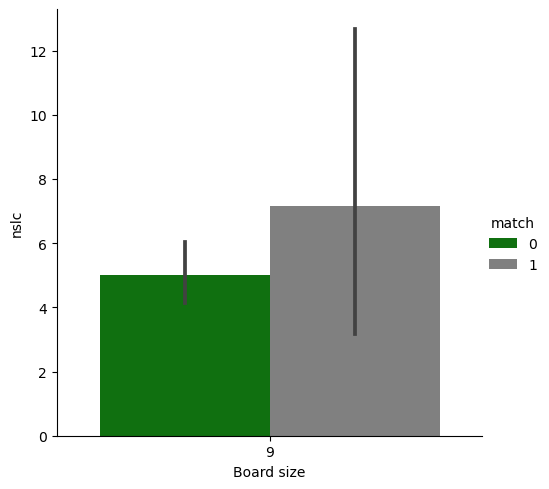

In [11]:
plot_error_distance(att_df)

In [12]:
m_means = pd.DataFrame(att_df[att_df['match']==1]).groupby('board_size')
m_means.mean()

,match,random_match,tile_clicked,nslc,nsp,correct_tile
board_size,,,,,,
9,1.0,0.05,3.85,3.3,2.625,3.75


In [13]:
mm_means = pd.DataFrame(att_df[att_df['match']==0]).groupby('board_size')
mm_means.mean()['nslc'].to_numpy()

array([3.64])

In [14]:
arr= np.array(tot_clicks)

In [15]:
np.mean(arr, axis=1).shape

(1,)